In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. EDA

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
data = pd.read_csv("/kaggle/input/titanic/train.csv")

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Age, Cabin, Embarked에 null이 있다.

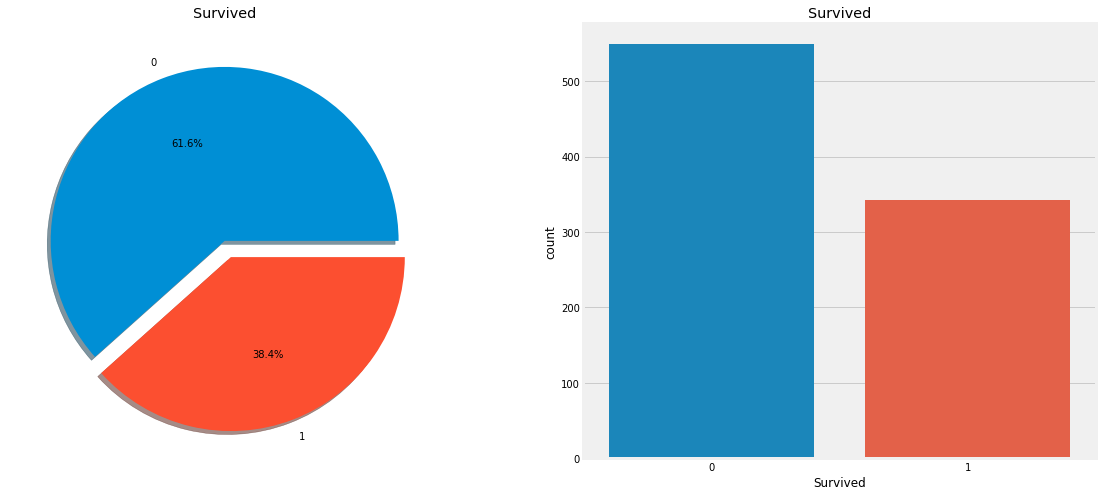

In [10]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Pieplot
data['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

# Countplot
sns.countplot('Survived', data=data, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

## 1.1 Analyzing the features

### Sex(categorical)

In [11]:
data.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

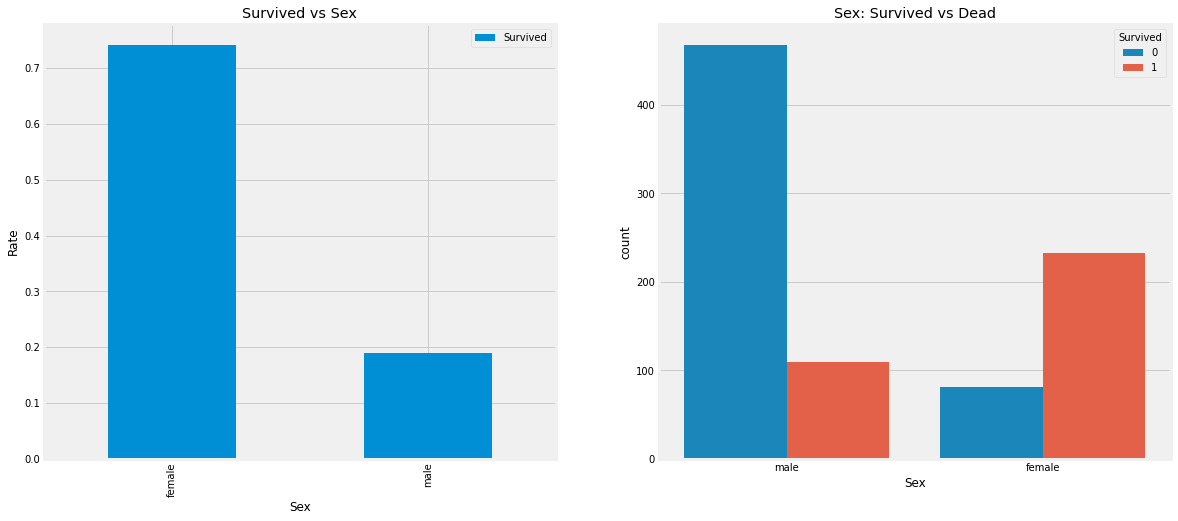

In [18]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# bar
data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
ax[0].set_ylabel('Rate')

# count plot
sns.countplot('Sex', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

### Pclass (ordinal)

In [14]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


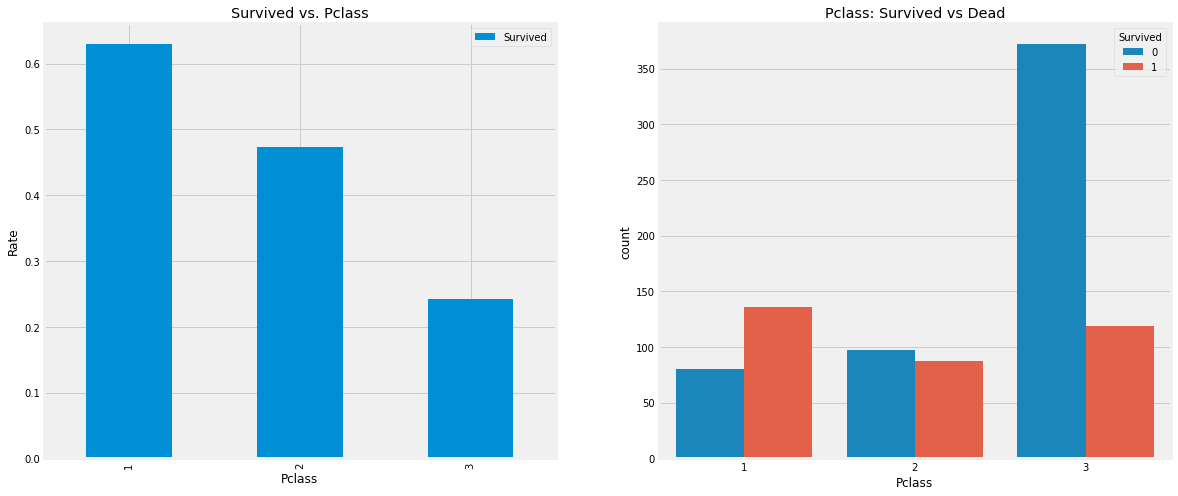

In [19]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# bar
# data['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0])
data[['Pclass', 'Survived']].groupby(["Pclass"]).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs. Pclass')
ax[0].set_ylabel('Rate')

# count plot
sns.countplot('Pclass', hue='Survived', data=data, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead')
plt.show()

- 1, 2, 3등석의 생존률 각각 대략 63%, 48%, 24%
- 낮은 등석에 탄 사람일수록 생존률이 낮게 나왔다.

In [16]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient(cmap='summer_r')

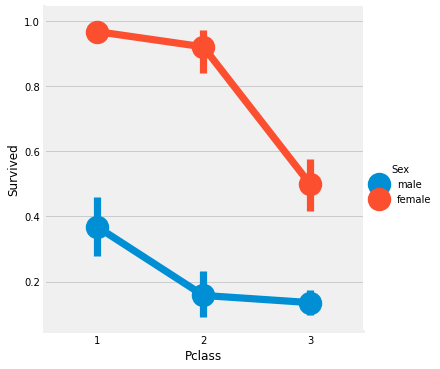

In [17]:
# factorplot
sns.factorplot('Pclass', 'Survived', hue='Sex', data=data)
plt.show()

- 여자이면서 1등석에 탄 사람은 생존률이 거의 95%~96%나 된다.
- 따라서 Pclass와는 무관하게 성별이 여자이면 구조 우선순위가 높다느 것을 알 수 있다.

### Age (continuous)

In [20]:
print('Oldest Passenger was of: ', data["Age"].max())
print("Youngest passenger was of: ", data["Age"].min())
print("Average passenger was of: ", data["Age"].mean())

Oldest Passenger was of:  80.0
Youngest passenger was of:  0.42
Average passenger was of:  29.69911764705882


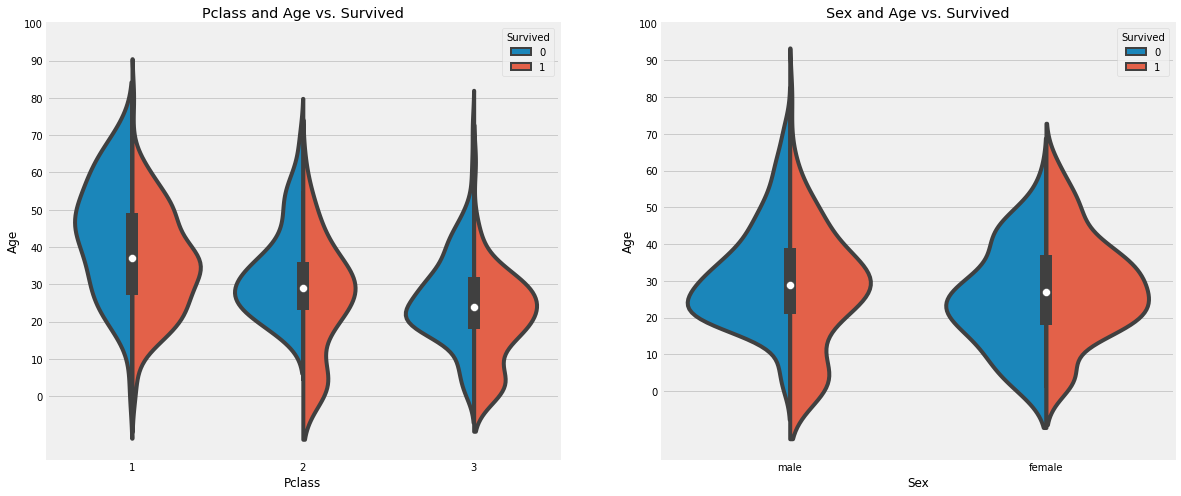

In [21]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# violin plots
sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_title("Pclass and Age vs. Survived")
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True, ax=ax[1])
ax[1].set_title("Sex and Age vs. Survived")
ax[1].set_yticks(range(0, 110, 10))

plt.show()

Age feature에는 null 값이 많았는데, 단순히 평균값을 사용하거나 지우는 것은 적절하지 못해보인다. 따라서, Name feature로 이 값을 채워보자.

In [22]:
data["Initial"] = 0
for i in data:
    data["Initial"] = data.Name.str.extract('([A-Za-z]+)\.')

In [23]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient()

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 결과 값들을 Mr/Mrs/Master/Miss/Other의 5가지 category로 바꾸자

In [24]:
data.Initial.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [25]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [27]:
data.groupby("Initial")["Age"].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

- 위의 다섯가지 카테고리에 나이를 지정해준다.

In [28]:
data.loc[(data.Age.isnull()) & (data.Initial=="Mr"), "Age"] = 33
data.loc[(data.Age.isnull()) & (data.Initial=="Mrs"), "Age"] = 36
data.loc[(data.Age.isnull()) & (data.Initial=="Master"), "Age"] = 5
data.loc[(data.Age.isnull()) & (data.Initial=="Miss"), "Age"] = 22
data.loc[(data.Age.isnull()) & (data.Initial=="Other"), "Age"] = 46

In [29]:
data.Age.isnull().any()

False

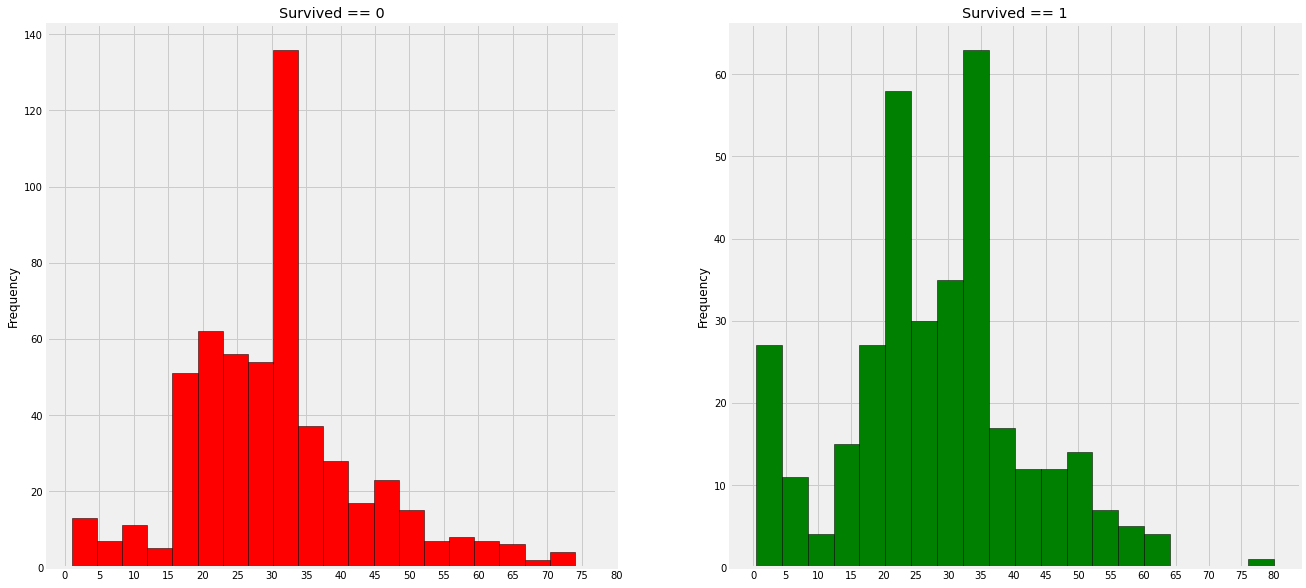

In [30]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

# histogram - dead
data[data["Survived"] == 0].Age.plot.hist(ax=ax[0], bins=20, edgecolor="black", color="red")
ax[0].set_title("Survived == 0")
x1 = list(range(0, 85, 5))
ax[0].set_xticks(x1)

# histogram - survived
data[data["Survived"] == 1].Age.plot.hist(ax=ax[1], bins=20, edgecolor="black", color="green")
ax[1].set_title("Survived == 1")
x2 = list(range(0, 85, 5))
ax[1].set_xticks(x2)

plt.show()

- 0\~5세의 생존률이 가장 높고, 30\~40대의 생존률의 가장 낮다.


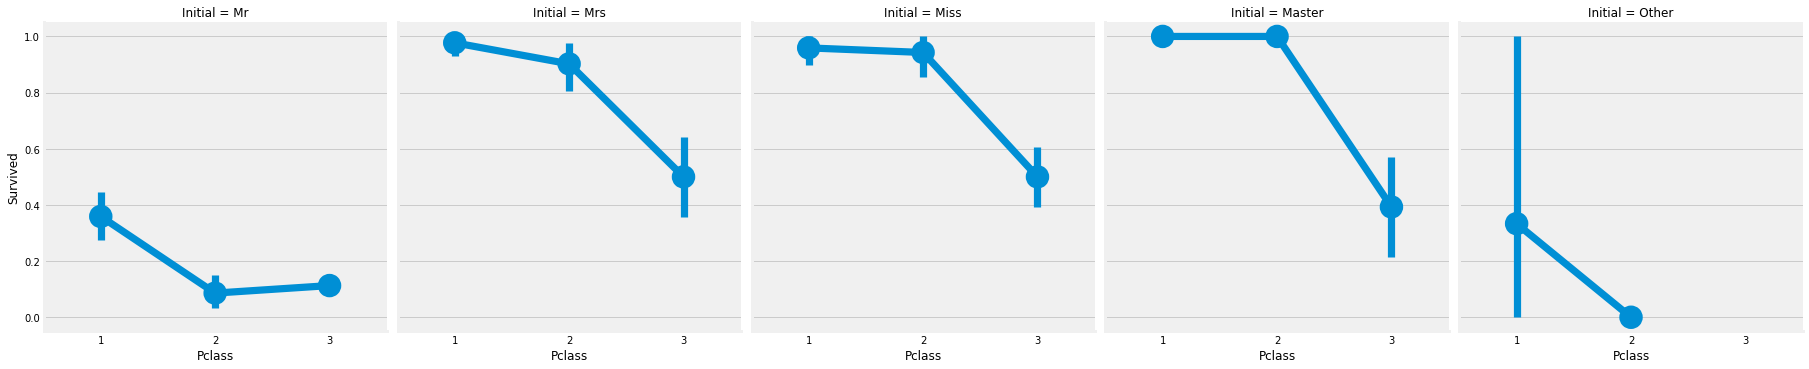

In [31]:
sns.factorplot("Pclass", "Survived", col="Initial", data=data)
plt.show()

### Embarked (categorical)

In [32]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient()

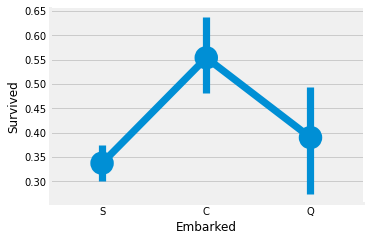

In [33]:
sns.factorplot("Embarked", "Survived", data=data)
plt.gcf().set_size_inches(5, 3)
plt.show()

- C항에서 승선한 사람들의 생존률이 가장 높고, S항에서 승선한 사람들의 생존률이 가장 낮다.

=> Embark는 유의미한 데이터일까??

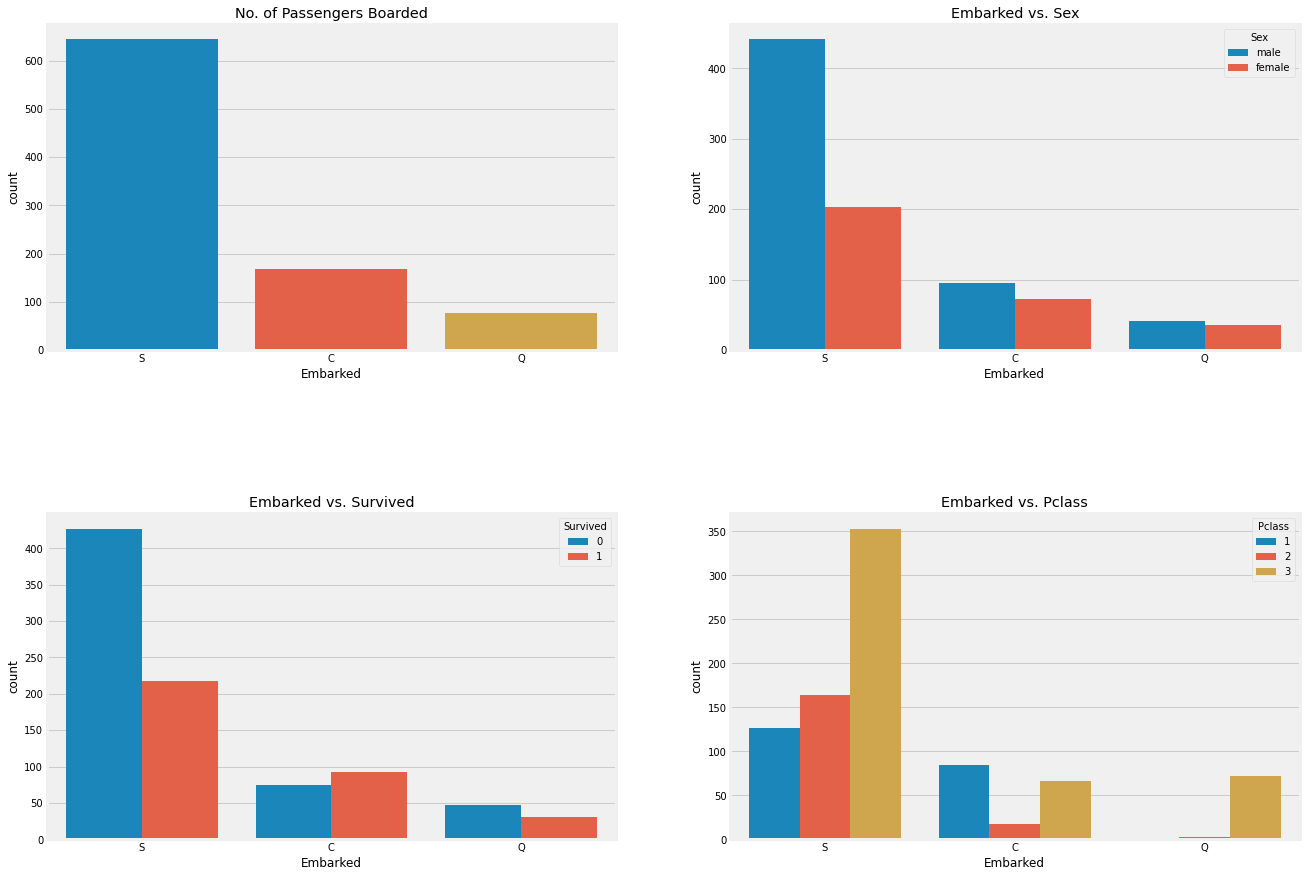

In [34]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot("Embarked", data=data, ax=ax[0, 0])
ax[0, 0].set_title("No. of Passengers Boarded")

sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
ax[0, 1].set_title("Embarked vs. Sex")

sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
ax[1, 0].set_title("Embarked vs. Survived")

sns.countplot("Embarked", hue="Pclass", data=data, ax=ax[1, 1])
ax[1, 1].set_title("Embarked vs. Pclass")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- S항에서 가장 많이 탑승했고, 이들은 대부분 Pclass이다.

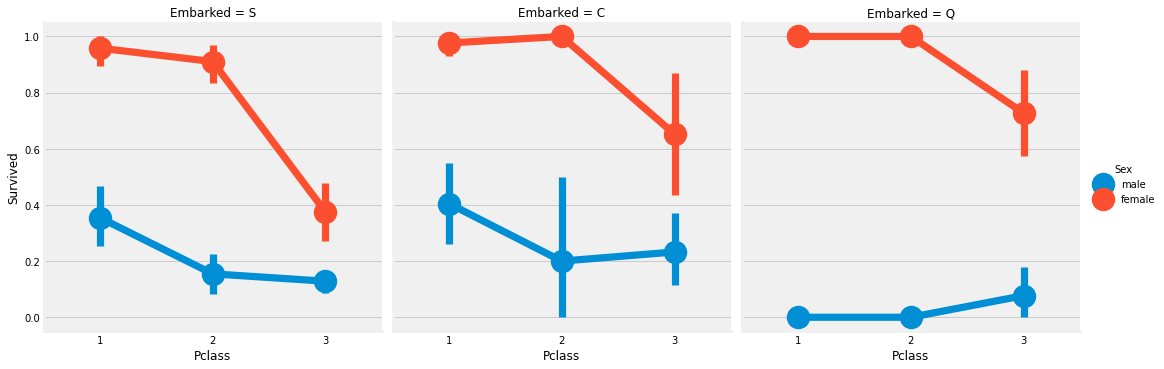

In [35]:
sns.factorplot("Pclass", "Survived", hue="Sex", col="Embarked", data=data)
plt.show()

- Q 항에서 탑승한 남자 승객 대부분 사망

In [37]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Initial          0
dtype: int64

In [38]:
# Embarked는 널 값이 2개밖에 없으므로, 가장 많은 탑승객이 있는 S항으로 채운다.
data["Embarked"].fillna("S", inplace=True)
data.Embarked.isnull().any()

False

### SibSp (discrete)

In [39]:
pd.crosstab(data.SibSp, data.Survived, margins=True).style.background_gradient()

Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
All,549,342,891


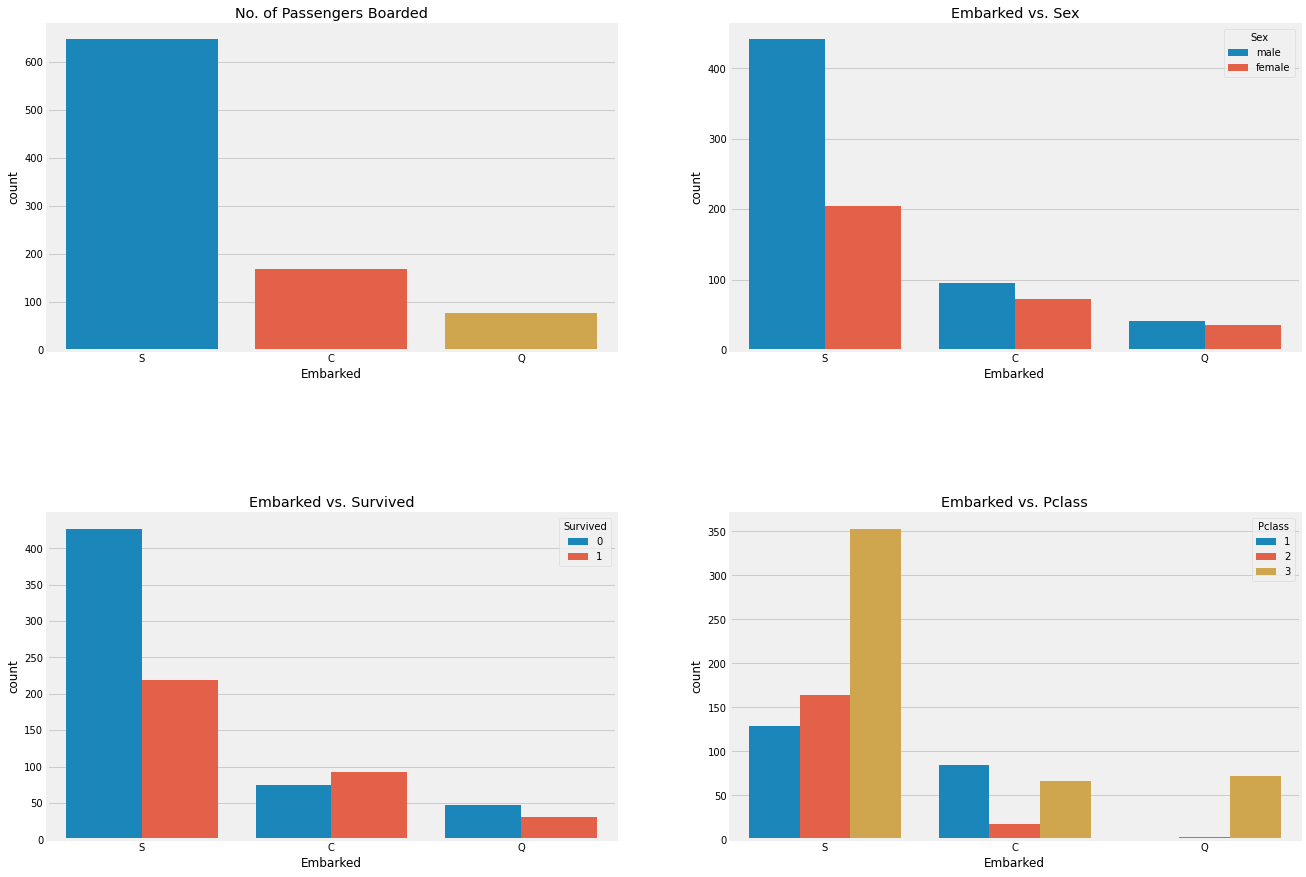

In [40]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot("Embarked", data=data, ax=ax[0, 0])
ax[0, 0].set_title("No. of Passengers Boarded")

sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
ax[0, 1].set_title("Embarked vs. Sex")

sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
ax[1, 0].set_title("Embarked vs. Survived")

sns.countplot("Embarked", hue="Pclass", data=data, ax=ax[1, 1])
ax[1, 1].set_title("Embarked vs. Pclass")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

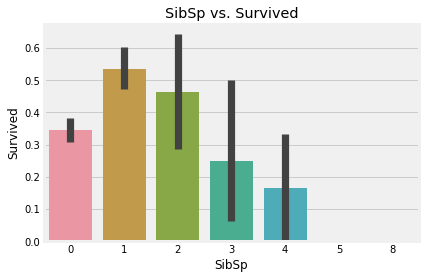

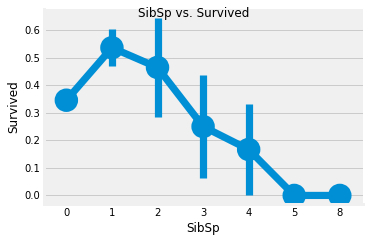

In [41]:
f = sns.barplot("SibSp", "Survived", data=data)
f.set_title("SibSp vs. Survived")

f = sns.factorplot("SibSp", "Survived", data=data)
f.fig.suptitle("SibSp vs. Survived")
plt.gcf().set_size_inches(5, 3)

plt.show()

- 형제가 없으면 생존률 감소

In [42]:
pd.crosstab([data.SibSp, data.Survived], data.Pclass).style.background_gradient()

- 형제수가 3이상인 경우 대부분 3클래스

### Parch

In [43]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient()

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


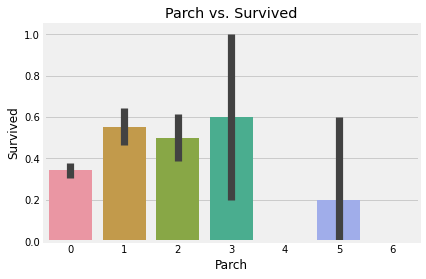

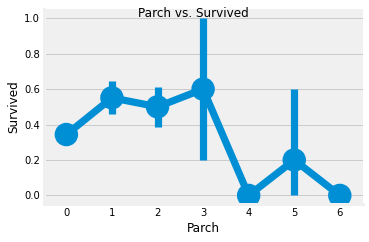

In [45]:
f = sns.barplot("Parch", "Survived", data=data)
f.set_title("Parch vs. Survived")

f = sns.factorplot("Parch", "Survived", data=data)
f.fig.suptitle("Parch vs. Survived")
plt.gcf().set_size_inches(5, 3)

plt.show()

### Fare (continuous)

In [46]:
print("Highest fare was: ", data["Fare"].max())
print("Lowest fare was: ", data["Fare"].min())
print("Average fare was: ", data["Fare"].mean())

Highest fare was:  512.3292
Lowest fare was:  0.0
Average fare was:  32.2042079685746


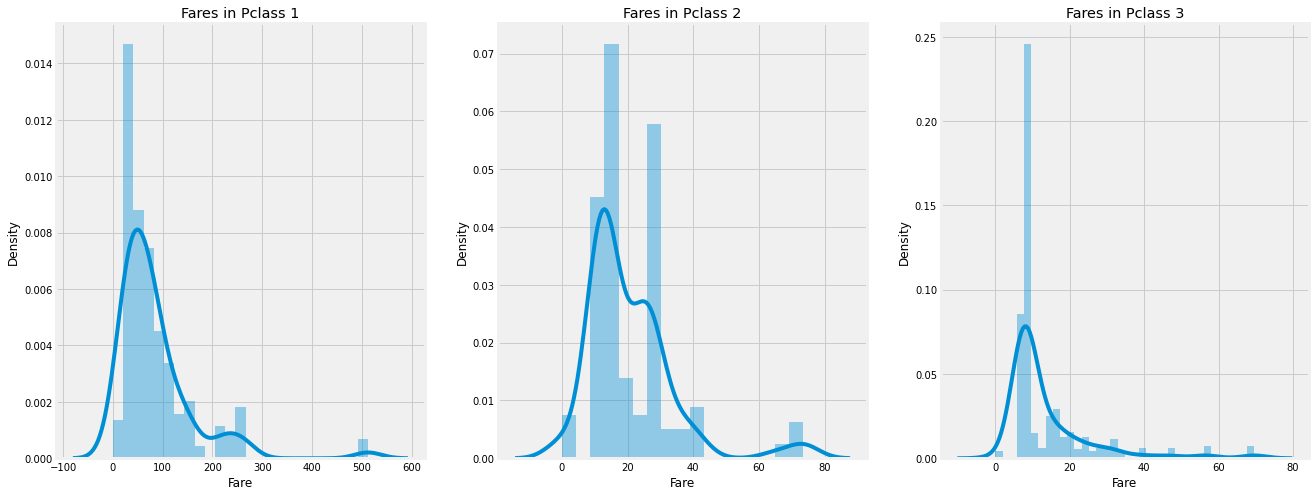

In [47]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.distplot(data[data["Pclass"] == 1].Fare, ax=ax[0])
ax[0].set_title("Fares in Pclass 1")

sns.distplot(data[data["Pclass"] == 2].Fare, ax=ax[1])
ax[1].set_title("Fares in Pclass 2")

sns.distplot(data[data["Pclass"] == 3].Fare, ax=ax[2])
ax[2].set_title("Fares in Pclass 3")

plt.show()

- class1의 비용이 높다

## 1.2 Observtions in a Nutshell for all features

## 1.3 Correlation Between The Features

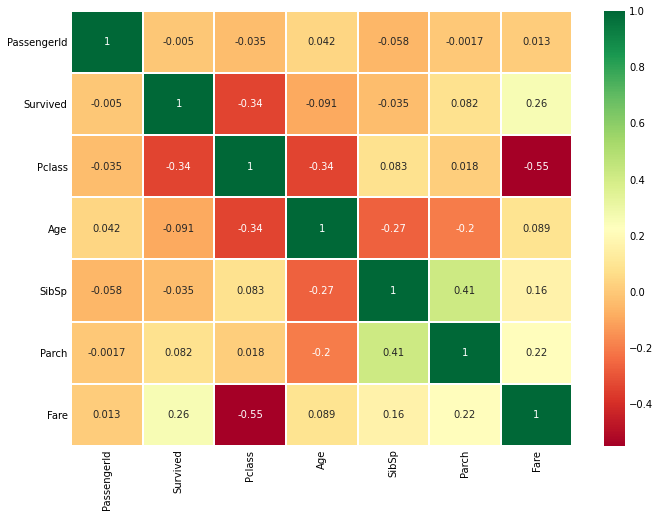

In [48]:
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=0.2)
plt.gcf().set_size_inches(10, 8)
plt.show()

# 2. Feature Engineering and Data Cleaning

In [50]:
# 5개 구간으로 나눈다
data["Age_band"] = 0
data.loc[data["Age"] <= 16, "Age_band"] = 0
data.loc[(data["Age"] > 16) & (data["Age"] <= 32), "Age_band"] = 1
data.loc[(data["Age"] > 32) & (data["Age"] <= 48), "Age_band"] = 2
data.loc[(data["Age"] > 48) & (data["Age"] <= 64), "Age_band"] = 3
data.loc[data["Age"] > 64, "Age_band"] = 4

data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [51]:
data["Age_band"].value_counts()

1    382
2    325
0    104
3     69
4     11
Name: Age_band, dtype: int64

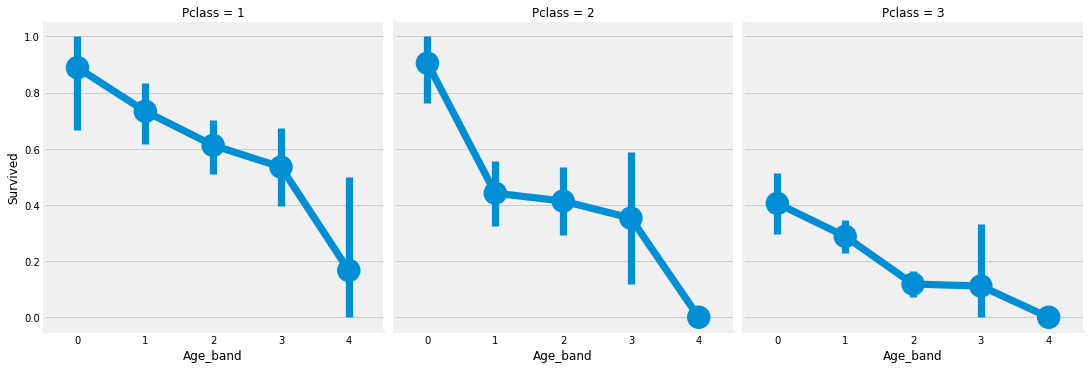

In [52]:
sns.factorplot("Age_band", "Survived", data=data, col="Pclass")
plt.show()

## Family Size 재조정

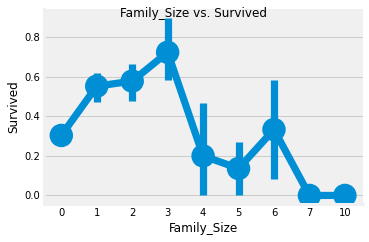

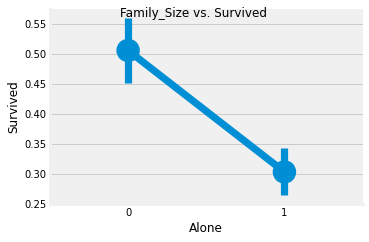

In [53]:
# Family_Size
data["Family_Size"] = 0
data["Family_Size"] = data["Parch"] + data["SibSp"]

# Alone
data["Alone"] = 0
data.loc[data.Family_Size == 0, "Alone"] = 1

f = sns.factorplot("Family_Size", "Survived", data=data)
f.fig.suptitle("Family_Size vs. Survived")
plt.gcf().set_size_inches(5, 3)

f = sns.factorplot("Alone", "Survived", data=data)
f.fig.suptitle("Family_Size vs. Survived")
plt.gcf().set_size_inches(5, 3)

plt.show()

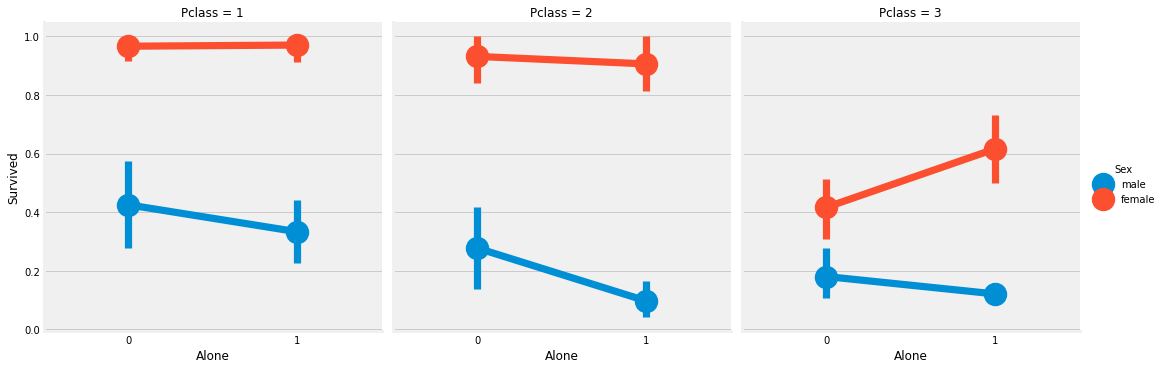

In [55]:
sns.factorplot("Alone", "Survived", data=data, hue="Sex", col="Pclass")
plt.show()

## Fare_Range

fare도 continuous feature이기 때문에 ordinal value로 바꾸어주자.

In [56]:
data["Fare_Range"] = pd.qcut(data["Fare"], 4)
data.groupby("Fare_Range")["Survived"].mean().to_frame().style.background_gradient()

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [57]:
data["Fare_cat"] = 0
data.loc[data["Fare"] <= 7.91, "Fare_cat"] = 0
data.loc[(data["Fare"] > 7.91) & (data["Fare"] <= 14.454), "Fare_cat"] = 1
data.loc[(data["Fare"] > 14.454) & (data["Fare"] <= 31.0), "Fare_cat"] = 2
data.loc[(data["Fare"] > 31.0) & (data["Fare"] <= 512.329), "Fare_cat"] = 3

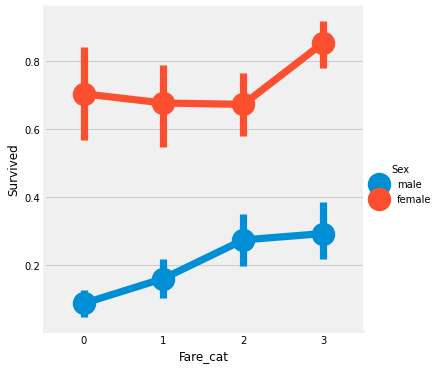

In [58]:
sns.factorplot("Fare_cat", "Survived", data=data, hue="Sex")
plt.show()

In [59]:
# 문자열 데이터 숫자로 바꿔주기
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].replace(["S", "C", "Q"], [0, 1, 2], inplace=True)
data["Initial"].replace(["Mr", "Mrs", "Miss", "Master", "Other"],
                        [0, 1, 2, 3, 4], inplace=True)


### Drop Unnecessty Features

In [60]:
data.drop(["Name", "Age", "Ticket", "Fare", "Cabin", "Fare_Range", "PassengerId"],
          axis=1, inplace=True)

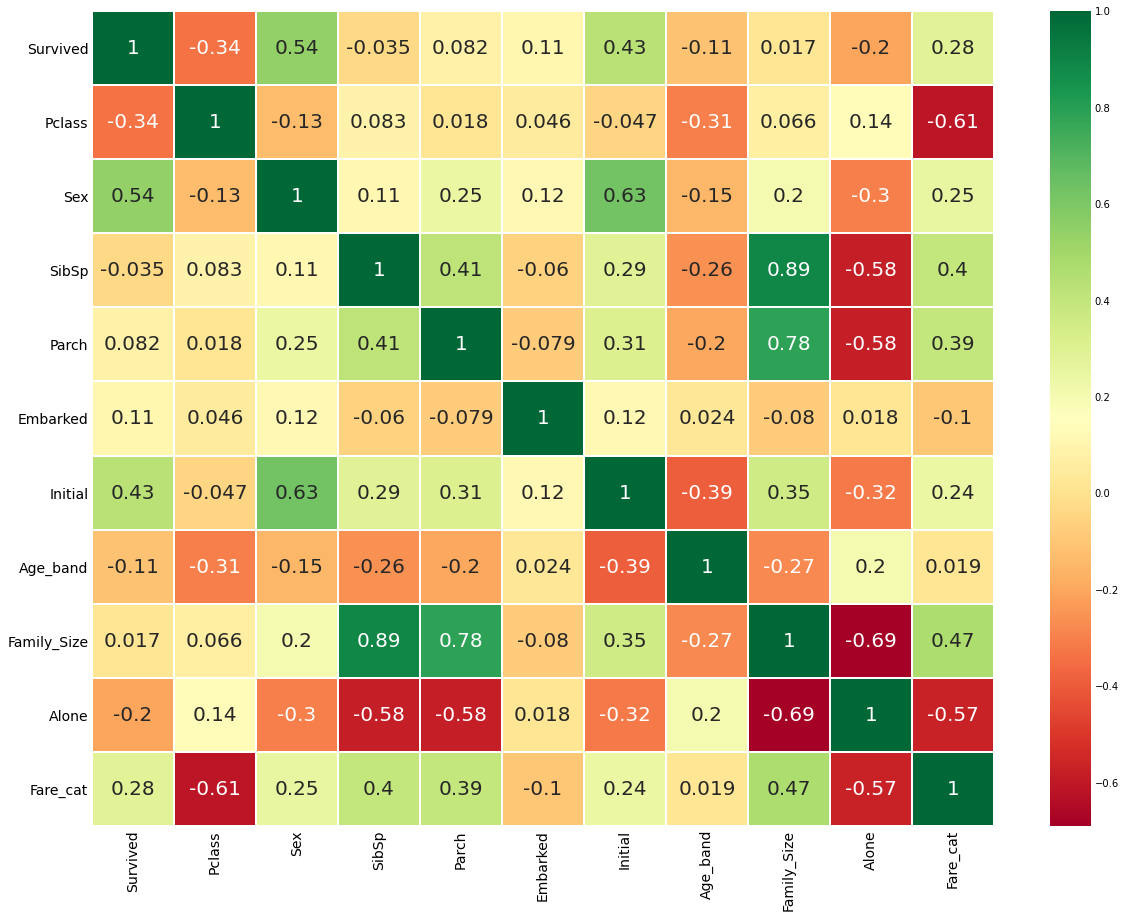

In [61]:
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn",
            linewidths=0.2, annot_kws={"size": 20})

plt.gcf().set_size_inches(18, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()